# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [3]:
#this libarys are needed tensorflow==2.11.1 tensorflow-io==0.31.0 matplotlib and also a Pythonversion like 3.10.0

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)


ERROR: Ignored the following versions that require a different python version: 0.28.0 Requires-Python >=3.7, <3.11
ERROR: Could not find a version that satisfies the requirement tensorflow-io==0.32.0 (from versions: 0.29.0, 0.30.0, 0.31.0)
ERROR: No matching distribution found for tensorflow-io==0.32.0


## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [3]:
FLASCHEN_FILE = os.path.join('praktikumsoundproben', 'flasche', 'New Recording 2.wav')
NOT_FLASCHEN_FILE = os.path.join('praktikumsoundproben', 'andere', 'New Recording 103.wav')
FLASCHEN_FILE

'praktikumsoundproben\\flasche\\New Recording 2.wav'

## 2.2 Build Dataloading Function

In [4]:
def load_wav_8k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes to 8000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000) #testing with 6k
    return wav


In [5]:
    file_contents = tf.io.read_file(FLASCHEN_FILE)
    file_contents


<tf.Tensor: shape=(), dtype=string, numpy=b'RIFF\xf4\xfb\x03\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\x00w\x01\x00\x02\x00\x10\x00data\xd0\xfb\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

## 2.3 Plot Wave

In [6]:
wave = load_wav_8k_mono(FLASCHEN_FILE)
nwave = load_wav_8k_mono(NOT_FLASCHEN_FILE)

wave

<tf.Tensor: shape=(21756,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , ..., 0.00138829, 0.00121894,
       0.00108733], dtype=float32)>

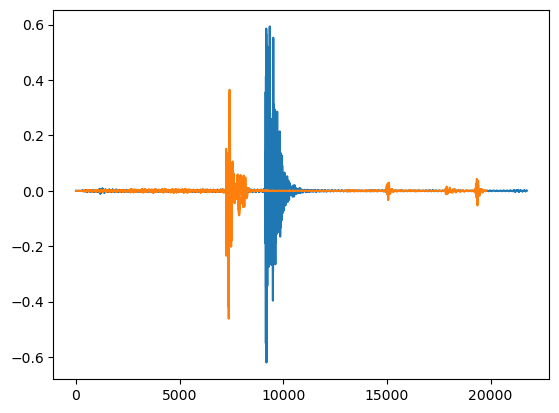

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [8]:
POS = os.path.join('praktikumsoundproben', 'flasche')
NEG = os.path.join('praktikumsoundproben', 'andere')

## 3.2 Create Tensorflow Datasets

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of the watterbottlesound

## 4.1 Calculate Wave Cycle Length

In [11]:
lengths = []
for file in os.listdir(os.path.join('praktikumsoundproben', 'flasche')):
    tensor_wave = load_wav_8k_mono(os.path.join('praktikumsoundproben', 'flasche', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=17839>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=6468>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=42924>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_8k_mono(file_path)
    wav = wav[:25000]                    #adjusting arround meanleangth of audio
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

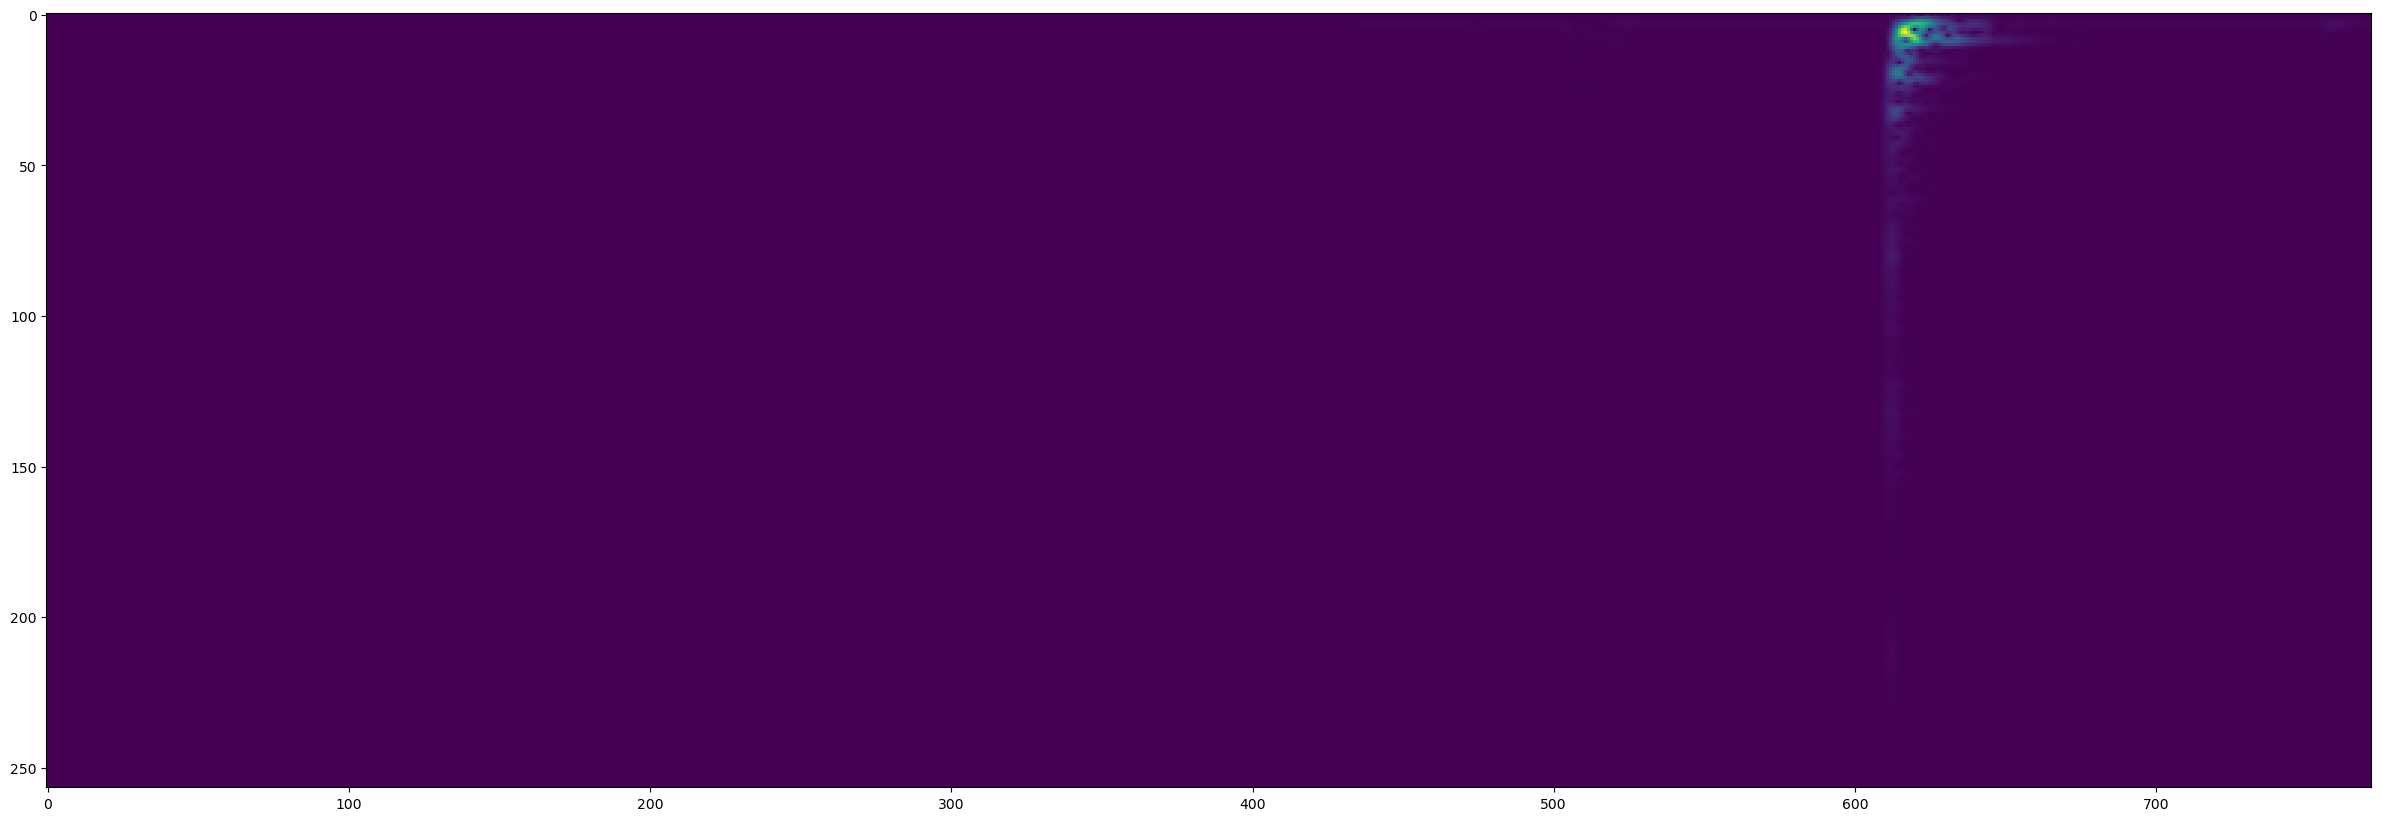

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [19]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## 6.2 Split into Training and Testing Partitions

In [20]:
len(data)

10

In [21]:
train = data.take(7)
test = data.skip(7).take(3)

## 6.3 Test One Batch

In [22]:
samples, labels = train.as_numpy_iterator().next()

In [23]:
samples.shape

(16, 772, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(772, 257, 1)))   #an 6k angepasst
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 770, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 768, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 3108864)           0         
                                                                 
 dense (Dense)               (None, 128)               397934720 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 397,937,329
Trainable params: 397,937,329
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [28]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
7/7 [==============================] - 78s 9s/step - loss: 11.0707 - recall: 0.5588 - precision: 0.7600 - val_loss: 4.4634 - val_recall: 0.4375 - val_precision: 0.8750
Epoch 2/4
7/7 [==============================] - 54s 8s/step - loss: 1.3385 - recall: 0.6027 - precision: 0.8800 - val_loss: 0.3268 - val_recall: 0.9600 - val_precision: 0.8571
Epoch 3/4
7/7 [==============================] - 53s 8s/step - loss: 0.4080 - recall: 0.9324 - precision: 0.8118 - val_loss: 0.3405 - val_recall: 1.0000 - val_precision: 0.8387
Epoch 4/4
7/7 [==============================] - 54s 8s/step - loss: 0.3656 - recall: 0.9306 - precision: 0.8272 - val_loss: 0.3369 - val_recall: 1.0000 - val_precision: 0.9333


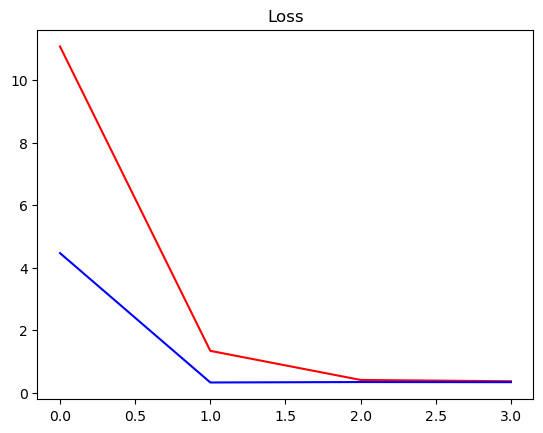

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

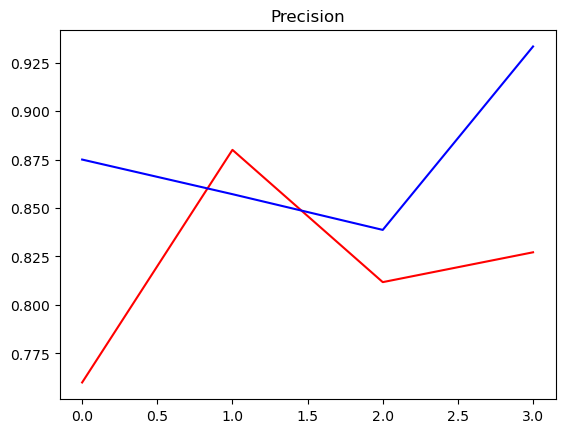

In [30]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

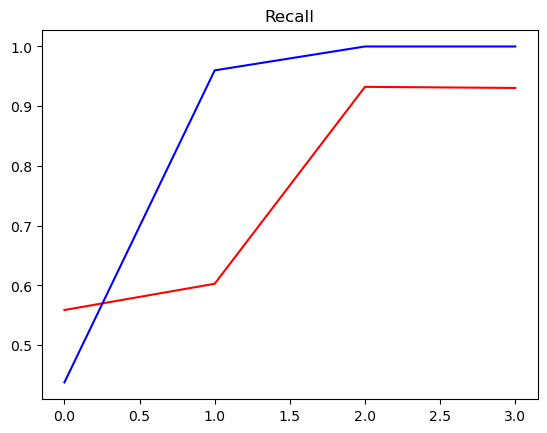

In [31]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [73]:
X_test, y_test = test.as_numpy_iterator().next()
y_test

array([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [74]:
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat


1/1 [==============================] - 1s 772ms/step


[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]

## 8.2 Convert Logits to Classes 

In [75]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Following Plans, not working: take MP3 and test it

## 9.1 Load up MP3s

In [76]:
def load_mp3_8k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 8kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 8 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=8000)
    return wav

In [107]:
mp3 = os.path.join('praktikumsoundproben', 'Aufnahmen', '2024_02_07_16_24_33.mp3') #Filepath, wo die MP3 abgelegt wird

In [108]:
wav = load_mp3_8k_mono(mp3)

In [109]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=25000, sequence_stride=25000, batch_size=1)

In [110]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [111]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([25000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [112]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=8000, sequence_stride=8000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [113]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 [==============================] - 0s 383ms/step


## 9.4 Group Consecutive Detections

In [114]:
from itertools import groupby

In [115]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [116]:
calls

0

## 9.5 Make Flask Server (later using the functions of 9)

In [ ]:
from flask import Flask, jsonify, request

app=Flask(__name__)

@app.route('/')
def hello_world():
    analysis={'result1': 1, 'result2':0}     #doesn´t get recognized in Android studio
    
    return analysis

@app.route('/<name>')
def user(name):
    return f"Hello {name} how are you"

if  __name__ == '__main__':
    app.run(host='0.0.0.0')